<a href="https://colab.research.google.com/github/Hey-El/TimeSeriesForecasting/blob/main/DrugReviewProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install transformers
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:

df=pd.read_excel('/content/DrugReview.xlsx')
df.shape

(53766, 7)

In [13]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4


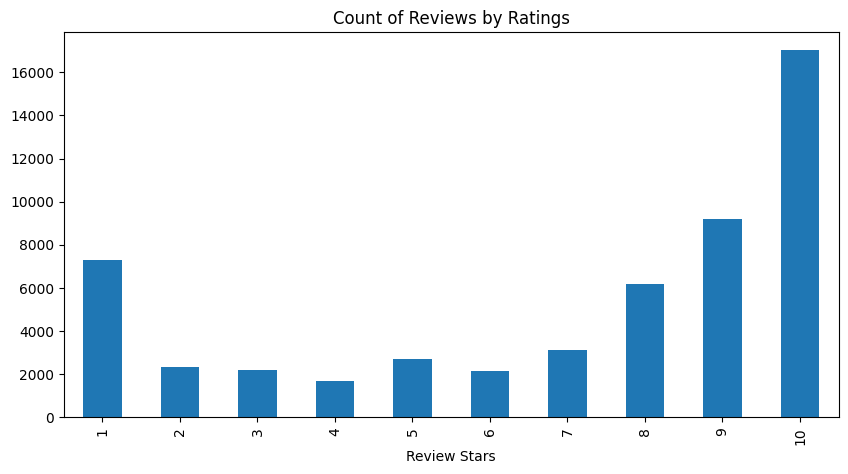

In [14]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Ratings',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [45]:
example = df['review'][50]
print(example)

"I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most likely am going to have to be in therapy."


In [25]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['``', 'I', '&', '#', '039', ';', 've', 'had', 'this', 'birth']

In [28]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('``', '``'),
 ('I', 'PRP'),
 ('&', 'CC'),
 ('#', '#'),
 ('039', 'CD'),
 (';', ':'),
 ('ve', 'NN'),
 ('had', 'VBD'),
 ('this', 'DT'),
 ('birth', 'NN')]

In [35]:
#can divide tokens into chunks

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  ``/``
  I/PRP
  &/CC
  #/#
  039/CD
  ;/:
  ve/NN
  had/VBD
  this/DT
  birth/NN
  control/NN
  for/IN
  a/DT
  year/NN
  now/RB
  and/CC
  at/IN
  first/JJ
  things/NNS
  were/VBD
  going/VBG
  good/JJ
  ,/,
  I/PRP
  only/RB
  had/VBD
  a/DT
  period/NN
  once/RB
  and/CC
  never/RB
  had/VBD
  one/CD
  since/IN
  but/CC
  now/RB
  I/PRP
  have/VBP
  super/JJ
  bad/JJ
  anxiety/NN
  ,/,
  I/PRP
  would/MD
  constantly/RB
  think/VB
  I/PRP
  was/VBD
  pregnant/JJ
  ,/,
  would/MD
  waste/VB
  my/PRP$
  money/NN
  on/IN
  pregnancy/NN
  test/NN
  even/RB
  though/IN
  I/PRP
  am/VBP
  (ORGANIZATION NOT/NNP)
  pregnant/JJ
  and/CC
  my/PRP$
  depression/NN
  was/VBD
  very/RB
  bad/JJ
  and/CC
  honestly/RB
  ,/,
  I/PRP
  really/RB
  don/VB
  &/CC
  #/#
  039/CD
  ;/:
  t/NN
  think/VBP
  it/PRP
  &/CC
  #/#
  039/CD
  ;/:
  s/PRP
  worth/IN
  it/PRP
  at/IN
  all/DT
  ./.
  I/PRP
  &/CC
  #/#
  039/CD
  ;/:
  m/CD
  getting/VBG
  it/PRP
  removed/VBD
  tomorrow/NN
  and/CC
  I/P

In [8]:
#VADER Sentiment Scoring

#This uses a "bag of words" approach:
#Stop words are removed
#each word is scored and combined to a total score.

sia = SentimentIntensityAnalyzer()
sia.polarity_scores('I am so happy!')
#compound score provided which is the overall sum of the scores for each categories assigned e.g negative etc

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [25]:
#using the tqdm library to display a progress bar while iterating through rows in a DataFrame and calculating sentiment scores using the sia.polarity_scores() function
# Initialize an empty dictionary to store results
result = {}

# Limit the loop to iterate through the first 1000 rows
for i, row in tqdm(df.head(1000).iterrows(), total=1000):
    review = row['review']
    res = sia.polarity_scores(review)
    result[i] = res



  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
vaders = pd.DataFrame(result).T
vaders.head()

,neg,neu,pos,compound
0,0.212,0.610,0.178,-0.4596
1,0.126,0.761,0.113,0.0736
2,0.000,1.000,0.000,0.0000
3,0.049,0.859,0.092,0.7086
4,0.039,0.810,0.151,0.9559


In [23]:
#.T to flip the rows into columns
vaders = pd.DataFrame(result).T
# Reset the index and rename the index column to match the original DataFrame
vaders.reset_index(inplace=True)
vaders.rename(columns={'index': 'Unnamed: 0'}, inplace=True)

# Left merge with the original DataFrame 'df' using 'Unnamed: 0' as the key
merged_df = df.merge(vaders, on='Unnamed: 0', how='left')
merged_df.head()




,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,neg,neu,pos,compound
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22,NaN,NaN,NaN,NaN
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17,NaN,NaN,NaN,NaN
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3,NaN,NaN,NaN,NaN
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35,NaN,NaN,NaN,NaN
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4,NaN,NaN,NaN,NaN


In [41]:
#filter the data by reviews that have been assigned a sentiment score as it doesn't seem like the first 1000 reviews have a score this could be due to the text in the reviews not meeting the criteria for the score to be applied
filtered_df = merged_df[merged_df['compound'].notna()]
filtered_df.head()



,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,neg,neu,pos,compound
484,397,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Took the shot 6-2014 and was bleeding 2 weeks...",1,"June 30, 2015",4,0.144,0.845,0.011,-0.9280
666,529,Medroxyprogesterone,Birth Control,"""I have been on depo now for about two years a...",4,"March 21, 2015",1,0.119,0.847,0.034,-0.6055
980,573,Medroxyprogesterone,Birth Control,"""I have been on the shot for 1 year. I have no...",9,"November 7, 2012",9,0.000,1.000,0.000,0.0000
1087,580,Medroxyprogesterone,Birth Control,"""I started Depo as an alternative to the pill ...",3,"September 27, 2012",13,0.132,0.762,0.106,-0.4767
1143,958,Rituxan,Non-Hodgkin's Lymphoma,"""Just finished my sixth round of chemo treatme...",9,"December 4, 2010",65,0.235,0.704,0.060,-0.9767


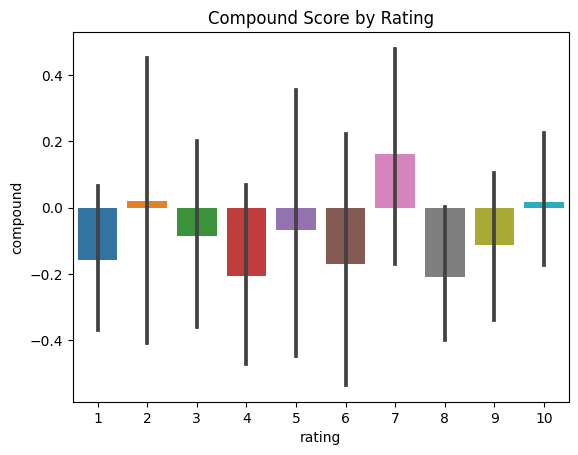

In [33]:
#plot results
ax = sns.barplot(data=filtered_df, x='rating', y='compound')
ax.set_title('Compound Score by Rating')
plt.show()

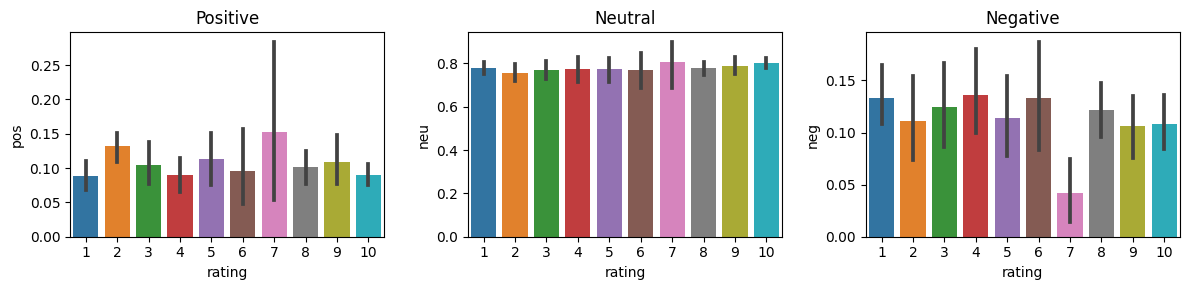

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=filtered_df, x='rating', y='pos', ax=axs[0])
sns.barplot(data=filtered_df, x='rating', y='neu', ax=axs[1])
sns.barplot(data=filtered_df, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

HuggingFace Transformer Roberta Pretrained Model

In [43]:
#pre-trained model that have previously been trained on twitter comments
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [46]:
# Run previous example for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
#transform it to numpy model
scores = output[0][0].detach().numpy()
#apply it to softmax
scores = softmax(scores)
#create scores dict e.g neg, neu and pos
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.95196587, 'roberta_neu': 0.04280928, 'roberta_pos': 0.0052248407}


In [47]:
sia.polarity_scores(example)

{'neg': 0.195, 'neu': 0.671, 'pos': 0.135, 'compound': -0.805}

In [48]:
print(example)

"I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most likely am going to have to be in therapy."


In [ ]:
result = {}

# Limit the loop to iterate through the first 1000 rows
for i, row in tqdm(df.head(1000).iterrows(), total=1000):
    review = row['review']
    res = sia.polarity_scores(review)
    result[i] = res